## Dataset from kaggle
https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

Original dataset
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=52758223

Gupta, A., & Gupta, R. (2019). ALL Challenge dataset of ISBI 2019 [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/tcia.2019.dc64i46r

In [1]:
# import needed libraries

import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import io
from io import BytesIO
import tensorflow
from tensorflow import keras
#import seaborn as sns
import matplotlib.pyplot as plt

2023-03-13 15:46:25.479377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1) Load Data


In [3]:
from google.cloud import storage

# Create a client object using the credentials file
client = storage.Client.from_service_account_json(credentials_path)
bucket = client.bucket('leukemic-1')

In [4]:
# setting files paths

all_0 = bucket.blob("C-NMC_Leukemia/training_data/fold_0/all")
all_1 = bucket.blob("C-NMC_Leukemia/training_data/fold_1/all")
all_2 = bucket.blob("C-NMC_Leukemia/training_data/fold_2/all")

hem_0 = bucket.blob("C-NMC_Leukemia/training_data/fold_0/hem")
hem_1 = bucket.blob("C-NMC_Leukemia/training_data/fold_1/hem")
hem_2 = bucket.blob("C-NMC_Leukemia/training_data/fold_2/hem")

In [5]:
def get_path_image(folder):
    image_paths = []
    for blob in bucket.list_blobs(prefix=folder.name):
        image_path = blob.name
        image_paths.append(image_path)
    return image_paths

In [6]:
# load training data

img_data = []

for i in [all_0,all_1,all_2,hem_0,hem_1,hem_2]:
    paths = get_path_image(i)
    
    img_data.extend(paths)
    
print(len(img_data))

10661


In [7]:
data_train = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data_train_df = pd.DataFrame(data_train) 
data_train_df

,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
1,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
2,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
3,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
4,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,NaN
...,...,...
10656,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10657,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10658,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN
10659,C-NMC_Leukemia/training_data/fold_2/hem/UID_h3...,NaN


In [8]:
data_train_df.loc[0:7272, 'labels'] = 1 # ALL
data_train_df.loc[7272:, 'labels'] = 0 # HEM

In [9]:
data_train_df['labels'].value_counts()

1.0    7272
0.0    3389
Name: labels, dtype: int64

In [10]:
data_train_df.head()

,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
1,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
2,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
3,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0
4,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1.0


In [11]:
data_train_df = data_train_df.sample(frac=1).reset_index(drop=True)

In [12]:
data_train_df.head()

,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/hem/UID_H1...,0.0
1,C-NMC_Leukemia/training_data/fold_1/all/UID_44...,1.0
2,C-NMC_Leukemia/training_data/fold_2/all/UID_47...,1.0
3,C-NMC_Leukemia/training_data/fold_2/all/UID_47...,1.0
4,C-NMC_Leukemia/training_data/fold_2/all/UID_68...,1.0


In [13]:
z = data_train_df.iloc[:7272, :]

In [14]:
z['labels'].value_counts()

1.0    4980
0.0    2292
Name: labels, dtype: int64

In [17]:
sample_df = data_train_df.iloc[1000:2000, :]
sample_df.reset_index(inplace=True, drop=True)
sample_df.head()

,img_data,labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_52...,1.0
1,C-NMC_Leukemia/training_data/fold_0/hem/UID_H1...,0.0
2,C-NMC_Leukemia/training_data/fold_2/hem/UID_H2...,0.0
3,C-NMC_Leukemia/training_data/fold_1/all/UID_44...,1.0
4,C-NMC_Leukemia/training_data/fold_1/all/UID_38...,1.0


In [18]:
sample_df['labels'].value_counts()

1.0    687
0.0    313
Name: labels, dtype: int64

In [19]:
from tqdm import tqdm

In [ ]:
sample_img_list = []
    
for i in tqdm(range(len(sample_df))):
    
    blob = bucket.blob(sample_df['img_data'][i])
    image_bytes = blob.download_as_bytes()
    nparr = np.frombuffer(image_bytes, np.uint8)
    image = cv.imdecode(nparr, cv.IMREAD_COLOR)
    sample_img_list.append(image)  

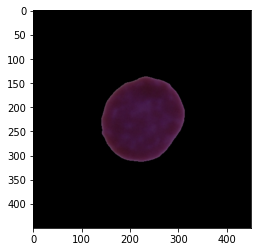

In [ ]:
plt.imshow(sample_img_list[99])
plt.show()

In [ ]:
X = np.array(sample_img_list)
y = np.array(sample_df['labels'])

In [ ]:
X.shape

(1000, 450, 450, 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_df = pd.DataFrame(y_val)

In [ ]:
y_df.value_counts()

1.0    129
0.0     71
dtype: int64

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(800, 450, 450, 3)
(800,)
(200, 450, 450, 3)
(200,)


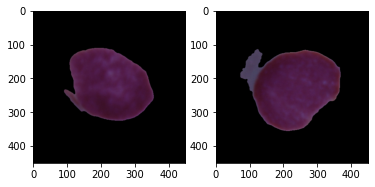

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[9]);
plt.subplot(1, 2, 2)
plt.imshow(X_val[8]);


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import models, layers

In [ ]:
def load_base_model():

  model = models.Sequential()

  model.add(Rescaling(1./450, input_shape=(450,450,3)))

  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.1))

  model.add(layers.Conv2D(16, (2, 2), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())

  model.add(layers.Dense(20))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
base_model_s = load_base_model()

In [ ]:
base_model_s.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 450, 450, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 450, 450, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 225, 225, 8)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 225, 225, 8)       0         
                                                                 
 flatten_2 (Flatten)         (None, 405000)            0         
                                                                 
 dense_4 (Dense)             (None, 10)                4050010   
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
es_base = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 20, 
                   verbose = 1, 
                   restore_best_weights = True)

In [ ]:
base_history = base_model_s.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              batch_size=64, callbacks=[es_base], epochs=25)


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
save_model_path = '/content/carolingio/saved_models/ddd/cnn_base_model_simple'
load_model_path = '/content/carolingio/saved_models/ddd/cnn_base_model_simple/saved_model.pb'
keras.models.save_model(base_model_s, save_model_path)
model_filename = 'cnn_base_model_simple'
client = storage.Client()
bucket = client.bucket('leukemic-1')
blob = bucket.blob(f"models/{model_filename}")
blob.upload_from_filename(load_model_path)

In [ ]:
base_model.evaluate(X_test, y_test)

In [ ]:
score = base_model.evaluate(X_test, y_test)[1]

In [ ]:
print(f"The accuracy of a baseline model is: {score}")

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    
    return model

In [ ]:
model_VGG16 = load_model()

In [ ]:
model_VGG16.summary()

In [ ]:
def set_nontrainable_layers(model):
    
    model.trainable=False
    
    return model

In [ ]:
model_VGG16 = set_nontrainable_layers(model_VGG16)

In [ ]:
model_VGG16.summary()

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    
    base_model = load_model()

    base_model = set_nontrainable_layers(base_model)

    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(2, activation='softmax')

    model = models.Sequential([
        base_model,
        flattening_layer,
        dense_layer,
        prediction_layer
        ])


    return model

In [ ]:
model_VGG16_complete = add_last_layers(model_VGG16)

In [ ]:
model_VGG16_complete.summary()

In [ ]:
from tensorflow.keras import optimizers

def build_model():
    
    model = model_VGG16_complete

    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='binary_crossentropy', optimizer= opt, metrics='accuracy')

    return model

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
X_train = preprocess_input(X_train) 
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [ ]:
model_ready = build_model()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20)

In [ ]:
history = model_ready.fit(X_train, y_train, validation_data=(X_val, y_val),
                          callbacks=[es], batch_size=64, epochs=100)

In [ ]:
y_train.shape

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
import matplotlib.pyplot as plot
plot_history(history)

In [ ]:
score = model_ready.evaluate(X_test, y_test)[1]

In [ ]:
print(f"The model accuracy on the test data is: {score}")

In [ ]:
def load_VGG16_model():

    VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    VGG_model.trainable=False

    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        VGG_model,
        flattening_layer,
        dense_layer,
        prediction_layer
        ])


    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='binary_crossentropy', optimizer= opt, metrics='accuracy')

    return model